In [1]:
import pandas as pd
import numpy as np
from DataGenerator import TimeSeriesGenerator
from statsmodels.tsa.api import SimpleExpSmoothing
import datetime as dt
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import cross_validate


# Linear time series

The following time series can be described as: $$ y_{t} = C_{t} \cdot X_{t}$$ 
so:

$$ Y_{t} = \sum_{i=1}^n C_{it} * X_{it}$$

The main idea behind our experimental setup is that the models are only given $X_{t}$ and essentially have to learn something that *closely* represents $C_{t}$. 

We can directly introduce drift by changing $C$ as from a certain timepoint $T=t$. Our main assumption is that given a change in $C_{t}$ there are retraining strategies to reduce the negative impact on $\hat{y}_{t}$, this is not our immediate focus.

We want to introduce drift in the aforementioned way *and* remove corresponding variable from the dataset that is given to the learner. Our goals are threefold:

- Can we identify when drift occurs?
- If so, can we find solutions to mitigate the impact of drift in the short term?
- Both being true: can this inform us on the optimal way and time to retrain our model(s)?

## No drift

The first case is a time series with additive noise and seasonality.

With the current seed the coefficients of the variables are as follows (with seed 42): 

[0.97562235, 0.7611397 , 0.78606431, 0.12811363, 0.45038594, 0.37079802, 0.92676499, 0.64386512, 0.82276161, 0.4434142]

The initial values for the time series are:
[8, 77, 65, 43, 43, 85,  8, 69, 20,  9]

At each time step these base values are multiplied by a random number uniformly sampled from [0.99, 1.04[

To generate values the coefficients matrix are multiplied with the values gotten from above to generate the variables.
Additionally the generateTrend(), generateSeasonality() can add trend and/or seasonality to any number of variables.

In [2]:
WithoutDrift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
WithoutDrift.generateTrend([0,2], [2,4])
WithoutDrift.generateSeasonality(periods=2, indices=0)
WithoutDrift.calculate()
WithoutDrift_df = WithoutDrift.toDataFrame(frequency='D')
WithoutDrift_df.head()

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-01-01,16.183167,77.387813,131.115810,42.796363,44.430877,85.280655,8.012825,69.613597,20.882844,9.340092,310.716084,2016,52,7
2017-01-02,16.651882,79.242066,131.984156,43.808480,44.905381,86.755473,8.090429,70.961153,20.455367,8.976971,317.857831,2017,1,1
2017-01-03,16.662929,77.677563,132.750176,43.547414,44.689613,86.406187,8.281680,68.870067,20.909580,9.169502,311.402077,2017,1,2
2017-01-04,16.875518,77.345682,130.530088,43.516148,44.421200,88.992976,8.241138,70.575268,20.338317,9.357225,318.757737,2017,1,3
2017-01-05,17.434068,77.583834,133.263388,43.589398,44.634201,89.080781,8.257756,68.978820,20.503364,8.974140,318.764127,2017,1,4


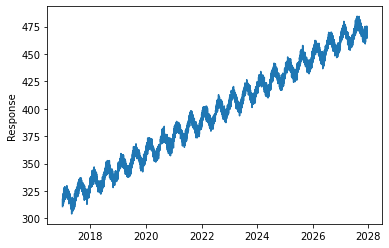

In [3]:
fig = sns.lineplot(data=WithoutDrift_df,x=WithoutDrift_df.index, y="Response")
plt.show()

### Training the model with full knowledge

In [4]:
X = WithoutDrift_df.drop("Response", axis="columns")
y = WithoutDrift_df["Response"].copy()
timeSeriesSPlits = TimeSeriesSplit(
    n_splits=5,
    gap=20,
    max_train_size=3000,
    test_size=200,
)

all_splits = list(timeSeriesSPlits.split(X, y))
train_0, test_0 = all_splits[0]

In [5]:
GBR_pipeline = make_pipeline(HistGradientBoostingRegressor())
RF_pipeline = make_pipeline(RandomForestRegressor())

In [6]:
def evaluate(model, X, y, cv):
    cv_results = cross_validate(
        model,
        X,
        y,
        cv=cv,
        scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
    )
    mae = -cv_results["test_neg_mean_absolute_error"]
    rmse = -cv_results["test_neg_root_mean_squared_error"]
    print(
        f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
        f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
    )

In [7]:
evaluate(GBR_pipeline, X, y, cv=timeSeriesSPlits)

Mean Absolute Error:     6.570 +/- 1.065
Root Mean Squared Error: 7.609 +/- 1.173


In [8]:
evaluate(RF_pipeline, X, y, cv=timeSeriesSPlits)

Mean Absolute Error:     7.313 +/- 1.641
Root Mean Squared Error: 8.432 +/- 1.721


In [10]:
GBR_pipeline.fit(X.iloc[:-200], y.iloc[:-200])
GBR_predictions = GBR_pipeline.predict(X.iloc[-200:])  
#GBR_residuals = y.iloc[:-200] - GBR_predictions

RF_pipeline.fit(X.iloc[:-200], y.iloc[:-200])
RF_predictions = RF_pipeline.predict(X.iloc[-200:]) 
#RF_residuals = y.iloc[:-200] - RF_predictions

SES_predictions = SimpleExpSmoothing(y).fit(smoothing_level=1).predict(-200, None)
SES_residuals = SimpleExpSmoothing(y).fit(smoothing_level=1).resid

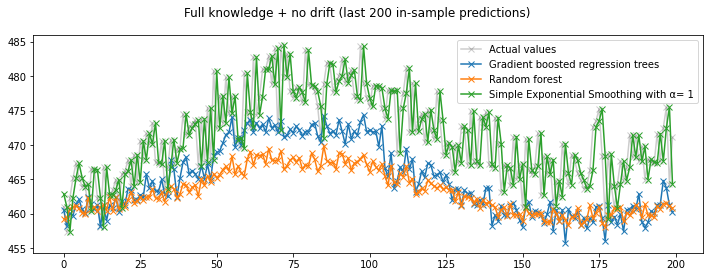

In [11]:
days = slice(-200, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + no drift (last 200 in-sample predictions)")
ax.plot(
    y.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    GBR_predictions[days],
    "x-",
    label="Gradient boosted regression trees",
)

ax.plot(
    RF_predictions[days],
    "x-",
    label="Random forest",
)

ax.plot(
    SES_predictions.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)
_ = ax.legend()


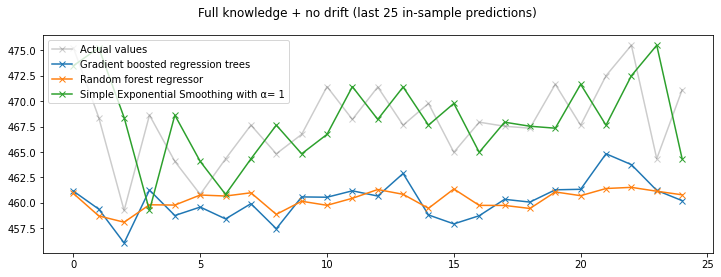

In [12]:
days = slice(-25, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + no drift (last 25 in-sample predictions)")
ax.plot(
    y.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    GBR_predictions[days],
    "x-",
    label="Gradient boosted regression trees",
)

ax.plot(
    RF_predictions[days],
    "x-",
    label="Random forest regressor",
)

ax.plot(
    SES_predictions.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)
_ = ax.legend()


In [14]:
SES_MAE = np.mean(np.abs(SES_residuals))
print(f"The MAE of SES is {SES_MAE}")

The MAE of SES is 3.836326223511656


#### Discussion

Both tree based models work pretty well out of the box as they have no problems capturing non-linear effects. A simple exponential smoothing model with α = 1 simply predicts the previous value at each time step. Currently as there are no strong deviations (e.g. one day having a significantly higher/lower level of sales) that punish this behaviour.

**Before we move to the case without full knowledge we need to make the data generator better. SES will outperform RF and GBRT since it only uses Y values either way.** 

Ways to improve the generation process: 

- ~~Include days of the week as a dummy variable and include coefficients for it. It should be lower on certain days.~~ This has been implemented through the weeklyPattern method.
- Same could be done for months.
- The next y-value could *explicitly* be a function of the previous one. This is currently not the case.
- Suggestions?

#### WeeklyPatterns

The coefficients are multiplied by [1.1, 1.05, 1.07, 1.03, 1.12, 1.07, 1.04] based on the day of the week. 

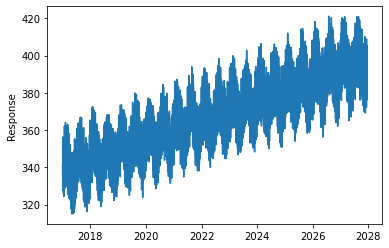

In [41]:
weeklyPattern = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
weeklyPattern.weeklyPattern()
weeklyPattern.generateTrend([0,2], [1.5,2])
weeklyPattern.generateSeasonality(periods=2, indices=0)
weeklyPattern.calculate()
weekly_df = weeklyPattern.toDataFrame(frequency='D')
X_WK = weekly_df.drop(columns="Response", axis = 1)
y_WK = weekly_df["Response"]
fig = sns.lineplot(data=weekly_df,x=weekly_df.index, y="Response")

plt.show()

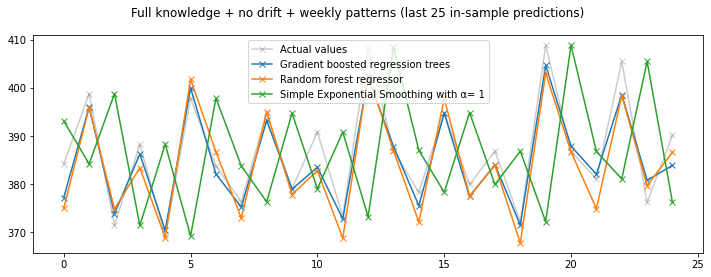

In [33]:
SES_predictions_WK = SimpleExpSmoothing(y_WK).fit(smoothing_level=1).predict(-200, None)
SES_residuals_WK = SimpleExpSmoothing(y_WK).fit(smoothing_level=1).resid

SES_8 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.8).predict(-200, None)
SES_8_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.8).resid

SES_6 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.6).predict(-200, None)
SES_6_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.6).resid

SES_4 = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.4).predict(-200, None)
SES_4_res = SimpleExpSmoothing(y_WK).fit(smoothing_level=0.4).resid


GBR_pipeline.fit(X_WK.iloc[:-200], y_WK.iloc[:-200])
GBR_predictions_WK = GBR_pipeline.predict(X_WK.iloc[-200:])  

RF_pipeline.fit(X_WK.iloc[:-200], y_WK.iloc[:-200])
RF_predictions_WK = RF_pipeline.predict(X_WK.iloc[-200:])



days = slice(-25, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + no drift + patterns (last 25 in-sample predictions)")
ax.plot(
    y_WK.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    GBR_predictions_WK[days],
    "x-",
    label="Gradient boosted regression trees",
)

ax.plot(
    RF_predictions_WK[days],
    "x-",
    label="Random forest regressor",
)
ax.plot(
    SES_predictions_WK.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)

_ = ax.legend()

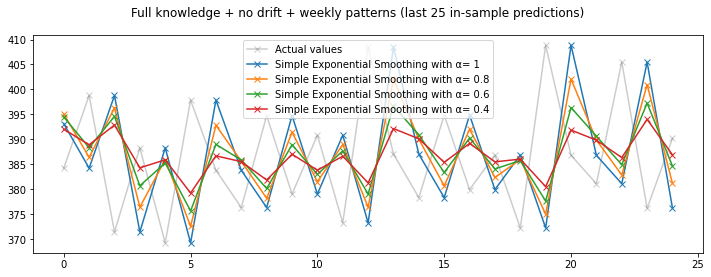

In [35]:
days = slice(-25, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Full knowledge + no drift + patterns (last 25 in-sample predictions)")
ax.plot(
    y_WK.values[days],
    "x-",
    alpha=0.2,
    label="Actual values",
    color="black",
)

ax.plot(
    SES_predictions_WK.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 1",
)

ax.plot(
    SES_8.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 0.8",
)

ax.plot(
    SES_6.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 0.6",
)

ax.plot(
    SES_4.values[days],
    "x-",
    label="Simple Exponential Smoothing with \u03B1= 0.4",
)
_ = ax.legend()

In [28]:
evaluate(GBR_pipeline, X_WK, y_WK, cv=timeSeriesSPlits)

Mean Absolute Error:     3.220 +/- 0.190
Root Mean Squared Error: 3.981 +/- 0.198


In [29]:
evaluate(RF_pipeline, X_WK, y_WK, cv=timeSeriesSPlits)

Mean Absolute Error:     4.025 +/- 0.371
Root Mean Squared Error: 4.915 +/- 0.388


In [38]:
MAE_1 = np.mean(np.abs(SES_residuals_WK))
MAE_8 = np.mean(np.abs(SES_8_res))
MAE_6 = np.mean(np.abs(SES_6_res))
MAE_4 = np.mean(np.abs(SES_4_res))

print(f"The MAE of SES with \u03B1 = 1 is {MAE_1}")
print(f"The MAE of SES with \u03B1 = 0.8 is {MAE_8}")
print(f"The MAE of SES with \u03B1 = 0.6 is {MAE_6}")
print(f"The MAE of SES with \u03B1 = 0.4 is {MAE_4}")

The MAE of SES with α = 1 is 16.35699508916023
The MAE of SES with α = 0.8 is 14.2509246605026
The MAE of SES with α = 0.6 is 12.414399866926408
The MAE of SES with α = 0.4 is 10.92287655844471


#### Discussion and conclusions

- When putting structural patterns into the data SES with \u03B1 = 1 doesn't do well anymore.
- The current approach of generating this type of seasonality was done by altering the "hidden" coefficients with a fixed rate.
  - 

## Drift

#### Sudden drift

In [ ]:
Drift = TimeSeriesGenerator(size=4000, amountOfVariables=10, seed=42)
Drift.generateSuddenDrift(-2,3500, 1.8)
Drift.generateTrend([0,2], [2,4])
Drift.generateSeasonality(periods=2, indices=0)
Drift.calculate()
Drift_df = Drift.toDataFrame(frequency='D')
Drift_df.head()

,Variable_0,Variable_1,Variable_2,Variable_3,Variable_4,Variable_5,Variable_6,Variable_7,Variable_8,Variable_9,Response,year,week,day
2017-01-01,16.183167,77.387813,131.115810,42.796363,44.430877,85.280655,8.012825,69.613597,20.882844,9.340092,310.716084,2016,52,7
2017-01-02,16.651882,79.242066,131.984156,43.808480,44.905381,86.755473,8.090429,70.961153,20.455367,8.976971,317.857831,2017,1,1
2017-01-03,16.662929,77.677563,132.750176,43.547414,44.689613,86.406187,8.281680,68.870067,20.909580,9.169502,311.402077,2017,1,2
2017-01-04,16.875518,77.345682,130.530088,43.516148,44.421200,88.992976,8.241138,70.575268,20.338317,9.357225,318.757737,2017,1,3
2017-01-05,17.434068,77.583834,133.263388,43.589398,44.634201,89.080781,8.257756,68.978820,20.503364,8.974140,318.764127,2017,1,4


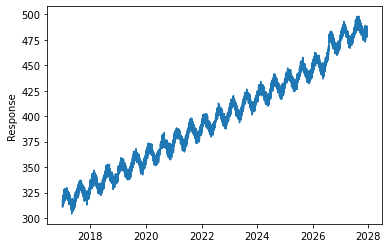

In [ ]:
fig = sns.lineplot(data=Drift_df,x=Drift_df.index, y="Response")
plt.show()